# Multi-Class Prediction of Obesity Risk

**Programa de Engenharia de Sistemas e Computação**

**CPS833 - Data Mining**

**Professor**: Geraldo Zimbrão da Silva

**Aluno**: Luiz Henrique Souza Caldas

## Importação de bibliotecas

In [99]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Pré-processamento

In [100]:
# Importação dos dados
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

# Verificação de dados ausentes (limpeza de dados)
print(f"{train_dataset.isnull().any().sum()} dados faltantes no dataset de treino")
print(f"{train_dataset.isnull().any().sum()} dados faltantes no dataset de teste")

# Verificação de linhas duplicadas (redução de dimensionalidade)
print(f"{train_dataset.duplicated().sum()} linhas duplicadas no dataset de treino")
print(f"{train_dataset.duplicated().sum()} linhas duplicadas no dataset de teste")

# TODO Verificação de ouliers (redução de dimensionalidade)

# Codificando features categóricas com Label Encoder (transformação de dados)
label_encoder = LabelEncoder()

train_dataset_encoded = train_dataset.copy()  # Faz uma cópia do dataset de treino para evitar alterações no original
for col in train_dataset.columns:
    if train_dataset[col].dtype == 'object':  # Verifica se a coluna é categórica
        train_dataset_encoded[col] = label_encoder.fit_transform(train_dataset[col])

test_dataset_encoded = test_dataset.copy() # Faz uma cópia do dataset de teste para evitar alterações no original
for col in test_dataset.columns:
    if test_dataset[col].dtype == 'object':  # Verifica se a coluna é categórica
        test_dataset_encoded[col] = label_encoder.fit_transform(test_dataset[col])

# Separação entre features e labels no dataset de treinamento e remoção da coluna id nos dois datasets
features = train_dataset_encoded.iloc[:,1:17].values # features do dataset de treino removendo o id
labels = train_dataset_encoded.iloc[:,17].values # labels
test = test_dataset_encoded.drop(columns=['id']) # removendo o id do dataset de teste

# Escalonando os dados (transformação de dados)
scaler = StandardScaler()
features = scaler.fit_transform(features)
test = scaler.fit_transform(test)

0 dados faltantes no dataset de treino
0 dados faltantes no dataset de teste
0 linhas duplicadas no dataset de treino
0 linhas duplicadas no dataset de teste


## Seleção de Modelo
### Escolha da técnica

In [98]:
resultados_naive_bayes = []
resultados_logistica = []
resultados_forest = []
resultados_knn = []
resultados_svm = []

for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    
    naive_bayes = GaussianNB() # criação do modelo Naive Bayes
    scores = cross_val_score(naive_bayes, features, labels, cv=kfold) # validação cruzada do modelo Naive Bayes
    resultados_naive_bayes.append(scores.mean()) # avaliação do modelo Naive Bayes
    
    logistica = LogisticRegression(max_iter=300) # criação do modelo de Regressão Logística
    scores = cross_val_score(logistica, features, labels, cv=kfold) # treinamento do modelo de Regressão Logística
    resultados_logistica.append(scores.mean()) # avaliação do modelo de Regressão Logística

    random_forest = RandomForestClassifier(n_jobs=-1, random_state=i) # criação do modelo de Random Forest
    scores = cross_val_score(random_forest, features, labels, cv=kfold) # treinamento do modelo de Random Forest
    resultados_forest.append(scores.mean()) # avaliação do modelo de Random Forest

    knn = KNeighborsClassifier() # criação do modelo de k-NN 
    scores = cross_val_score(knn, features, labels, cv=kfold) # treinamento do modelo de k-NN 
    resultados_knn.append(scores.mean()) # avaliação do modelo de k-NN 

    svm = SVC() # criação do modelo de SVM
    scores = cross_val_score(svm, features, labels, cv=kfold) # treinamento do modelo de SVM
    resultados_svm.append(scores.mean()) # avaliação do modelo de SVM

KeyboardInterrupt: 

In [ ]:
print(f"Naïve Bayes com média {np.mean(resultados_naive_bayes)} e desvio padrão {np.std(resultados_naive_bayes)}")
print(f"Regressão Logística com média {np.mean(resultados_logistica)} e desvio padrão {np.std(resultados_logistica)}")
print(f"Random Forest com média {np.mean(resultados_forest)} e desvio padrão {np.std(resultados_forest)}")
print(f"k-NN com média {np.mean(resultados_knn)} e desvio padrão {np.std(resultados_knn)}")
print(f"SVM com média {np.mean(resultados_svm)} e desvio padrão {np.std(resultados_svm)}")

Naïve Bayes com média 0.6616730737980825 e desvio padrão 0.0
Regressão Logística com média 0.8589466536666899 e desvio padrão 0.0
Random Forest com média 0.8991232908512664 e desvio padrão 0.0
k-NN com média 0.747712004085707 e desvio padrão 0.0
SVM com média 0.863956473292012 e desvio padrão 0.0
Rede Neural com média 0.868292453049191 e desvio padrão 0.0


A técnica Random Forest obteve a maior média, então mesmo com seu desvio padrão sendo o maior, foi a técnica selecionada.

### Otimização dos hiperparâmetros com validação cruzada

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify = labels)

param_grid = {
    'bootstrap': [True],
    # 'max_depth': [80, 90, 100, 110],
    # 'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    # 'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 400, 600, 800, 1000]
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)
random_forest = grid_search.best_estimator_

In [ ]:
print(grid_search.best_params_)
y_predict = random_forest.predict(x_test)
resultado = accuracy_score(y_test, y_predict)
print(resultado)

{'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 400}
0.899325626204239


## Avaliação do modelo usando o dataset de treinamento

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify = labels)
    
naive_bayes = GaussianNB() # criação do modelo Naive Bayes
naive_bayes.fit(x_train,y_train) # treinamento do modelo Naive Bayes
y_predict_naive_bayes = naive_bayes.predict(x_test) # classificação com o modelo Naive Bayes
resultado_naive_bayes = accuracy_score(y_test, y_predict_naive_bayes) # percentual de acerto do modelo Naive Beyes

random_forest = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, n_jobs=-1) # criação do modelo de Random Forest
random_forest.fit(x_train,y_train) # treinamento do modelo de Random Forest
y_predict_forest = random_forest.predict(x_test) # classificação com o modelo Random Forest
resultado_forest = accuracy_score(y_test, y_predict_forest) # percentual de acerto do modelo Random Forest

A acurácia do Naïve Beyes foi de 0.6678709055876686
A acurácia do Random Forest foi de 0.9067919075144508


Avaliação dos resultados:

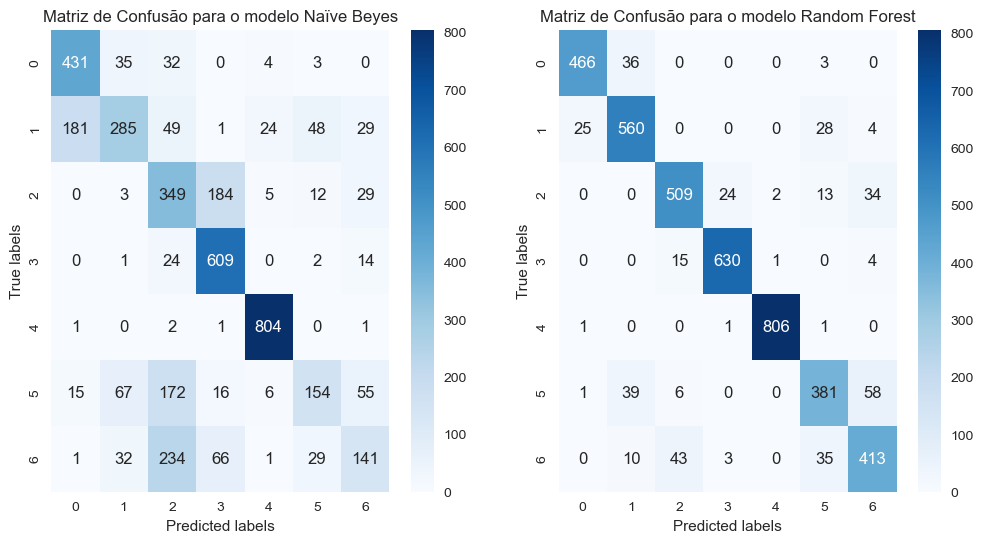

In [ ]:
# Decodificando os labels
mapeamento = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Obesity_Type_I",
    3: "Obesity_Type_II",
    4: "Obesity_Type_III",
    5: "Overweight_Level_I",
    6: "Overweight_Level_II"
}
y_predict_naive_bayes = [mapeamento[i] for i in y_predict_naive_bayes]
y_predict_forest = [mapeamento[i] for i in y_predict_forest]
y_test = [mapeamento[i] for i in y_test]

cm_nb = confusion_matrix(y_test, y_predict_naive_bayes)
cm_rf = confusion_matrix(y_test, y_predict_forest)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='d', ax=axs[0])
axs[0].set_title('Matriz de Confusão para o modelo Naïve Beyes')
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d', ax=axs[1])
axs[1].set_title('Matriz de Confusão para o modelo Random Forest')
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels');

print(f"A acurácia do Naïve Beyes foi de {resultado_naive_bayes}")
print(f"A acurácia do Random Forest foi de {resultado_forest}")

## Classificação do dataset de teste

In [107]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, n_jobs=-1) # criação do modelo de Random Forest
random_forest.fit(features,labels) # treinamento do modelo de Random Forest com o dataset de treinamento completo
y_predict_forest = random_forest.predict(test) # classificação com o modelo Random Forest

### Geração do CSV

In [108]:
mapeamento = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Obesity_Type_I",
    3: "Obesity_Type_II",
    4: "Obesity_Type_III",
    5: "Overweight_Level_I",
    6: "Overweight_Level_II"
}
predict_categorico = [mapeamento[i] for i in y_predict_forest]
resultado = np.column_stack((test_dataset['id'].values, predict_categorico))
np.savetxt('resuldado.csv', resultado, delimiter=',', header="id,NObeyesdad", fmt='%s', comments='')